In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

combined_data_file = "a549_combined_data.h5ad"

print(f"Loading combined dataset from {combined_data_file}...")
combined = sc.read_h5ad(combined_data_file)
print(f"Combined data shape: {combined.shape}")


Loading combined dataset from a549_combined_data.h5ad...
Combined data shape: (246262, 33388)


In [2]:
combined

AnnData object with n_obs × n_vars = 246262 × 33388
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'sample_id', 'batch', 'n_genes', 'perturbation', 'is_control', 'drug'
    var: 'gene_symbols', 'feature_types', 'n_cells'
    uns: 'log1p', 'rank_genes_groups'

/home/haonan.li/miniconda3/envs/scbasecamp_env/lib/python3.13/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


/tmp/ipykernel_3415189/308453643.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_3415189/308453643.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


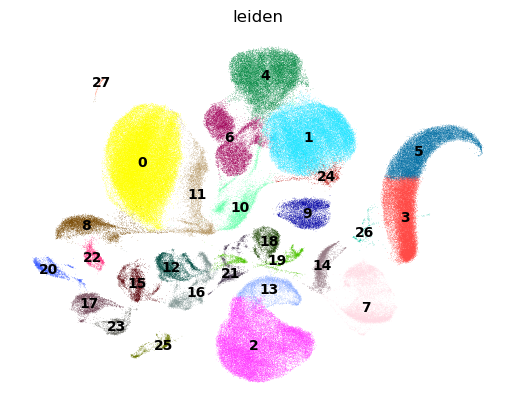

In [6]:
# Normalize and log transform
sc.pp.normalize_total(combined, target_sum=1e4)
# Check if data is already log-transformed
if combined.X.min() >= 0:  # Only log-transform if data isn't already logged
    sc.pp.log1p(combined)

# Identify highly variable genes
sc.pp.highly_variable_genes(combined, min_mean=0.0125, max_mean=3, min_disp=0.5)

# PCA and UMAP
sc.pp.pca(combined, n_comps=30, use_highly_variable=True)
sc.pp.neighbors(combined, n_neighbors=10, n_pcs=30)
sc.tl.umap(combined)

# Create a figure directory
fig_dir = "a549_analysis_figures"
os.makedirs(fig_dir, exist_ok=True)
sc.settings.figdir = fig_dir  # Add this line to set the default figure directory

# Plot UMAP colored by sample
plt.figure(figsize=(10, 8))
sc.pl.umap(combined, color='sample_id', frameon=False, 
           save=f'umap_by_sample.png',  # Remove os.path.join here
           show=False)  # Add show=False to prevent double plotting
plt.savefig(os.path.join(fig_dir, 'umap_by_sample.png'))
plt.close()
# Analysis of quality metrics across samples
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x='sample_id', y='n_genes', data=combined.obs, ax=axs[0])  

axs[0].set_title('Gene counts by sample')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

sns.boxplot(x='sample_id', y='umi_count', data=combined.obs, ax=axs[1])
axs[1].set_title('UMI counts by sample')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'qc_metrics_by_sample.png'))
plt.close()

# Cluster the cells
sc.tl.leiden(combined, resolution=0.5)
sc.pl.umap(combined, color='leiden', legend_loc='on data', frameon=False, 
          save='umap_clusters.png')

# Save the combined anndata object for further analysis
